
1. **`acceleration`**: Calcula la aceleración de la propagación del fuego basada en el tipo de combustible y la fracción de la corona quemada.

2. **`area`**: Calcula el área de un elipse, que representa la zona quemada, usando el diámetro mayor y menor.

3. **`back_fire_behaviour`**: Calcula el comportamiento del fuego en retroceso, incluyendo la tasa de propagación, la intensidad del fuego y el consumo de combustible en esa dirección.

4. **`backfire_isi`**: Calcula el Índice de Propagación Inicial (ISI) para fuegos de retroceso.

5. **`backfire_ros`**: Calcula la tasa de propagación del fuego de retroceso.

6. **`bui_effect`**: Calcula el efecto del Índice de Acumulación (BUI) en la propagación del fuego.

7. **`crit_surf_intensity`**: Calcula la intensidad crítica de la superficie, necesaria para que un fuego superficial transicione a un fuego de corona.

8. **`ffmc_effect`**: Calcula el efecto del Código de Humedad de Combustible Fino (FFMC) en la propagación del fuego.

9. **`final_ros`**: Calcula la tasa final de propagación del fuego, teniendo en cuenta si es un fuego de corona.

10. **`fire_intensity`**: Calcula la intensidad del fuego basada en el consumo de combustible y la tasa de propagación.

11. **`flank_fire_behaviour`**: Determina el comportamiento del fuego en los flancos, incluyendo la intensidad y el consumo de combustible.

12. **`foliar_moisture`**: Estima la humedad foliar basada en la ubicación geográfica y el día juliano.

13. **`rate_of_spread`**, **`ros_base`**, **`slope_effect`**: Estas funciones calculan la tasa de propagación del fuego basada en varios factores, incluyendo condiciones meteorológicas, tipo de combustible, y pendiente del terreno.

14. **`spread_distance`**: Calcula la distancia de propagación del fuego y la tasa de propagación a lo largo del tiempo.

15. **`surf_fuel_consump`**: Estima el consumo de combustible superficial basado en el tipo de combustible y condiciones meteorológicas.

16. **`length2breadth`**, **`perimeter`**: Estas funciones calculan la relación longitud-ancho y el perímetro de la zona quemada, respectivamente, basándose en la forma elíptica del avance del fuego.




1. **Aceleración (para combustibles cerrados):**
$$\text{accn} = 0.115 - 18.8 \times \text{cfb}^{2.5} \times e^{-8.0 \times \text{cfb}}$$

2. **Área del elipse:**
$$\text{areavar} = \frac{dt \times df \times \pi}{10000.0}$$
Donde \(dt\) es el diámetro total (longitud de la cabeza más la longitud de la cola del fuego) y \(df\) es el ancho del fuego.

3. **Intensidad del fuego:**
$$\text{fi} = 300.0 \times \text{fc} \times \text{ros}$$

4. **Intensidad crítica de la superficie:**
$$\text{csi} = 0.001 \times \text{cbh}^{1.5} \times (460.0 + 25.9 \times \text{fmc})^{1.5}$$

5. **Efecto FFMC (Fine Fuel Moisture Code):**
$$\text{ff} = 91.9 \times e^{-0.1386 \times mc} \times \left(1 + (mc^{5.31} / (4.93 \times 10^{7}))\right)$$
Donde $mc = 147.2 \times (101.0 - \text{ffmc}) / (59.5 + \text{ffmc})$.

6. **Tasa de propagación final (para fuegos de corona):**
$$\text{ros} = \text{rss} + \text{cfb} \times (\text{rsc} - \text{rss})$$

7. **Efecto de BUI (Buildup Index):**
$$\text{be} = e^{\text{bui\_avg} \times \log(q) \times ((1.0 / \text{bui}) - (1.0 / \text{bui0}))}$$

8. **ISI de retroceso:**
$$\text{bisi} = 0.208 \times \text{ff} \times e^{-0.05039 \times \text{wsv}}$$

9. **Relación longitud/ancho para diferentes tipos de combustibles:**
Para combustibles de tipo "O1a" o "O1b":
$$\text{lb} = 1.1 \times \text{ws}^{0.464}$$
Para otros tipos de combustibles:
$$\text{lb} = 1.0 + 8.729 \times (1.0 - e^{-0.030 \times \text{ws}})^{2.155}$$

10. **Perímetro del elipse:**
$$p = \frac{hdist + bdist}{2} \times \pi \times \left(1.0 + \frac{1.0}{\text{lb}}\right) \times \left(1.0 + \left(\frac{\text{lb} - 1.0}{2.0 \times (\text{lb} + 1.0)}\right)^2\right)$$

11. **Distancia de propagación:**
$$\text{sd} = \text{ros} \times \left(\text{time} + \frac{e^{-a \times \text{time}}}{a} - \frac{1}{a}\right)$$


In [302]:
import numpy as np
import math
import pandas as pd
import datetime

def acceleration(ftype, cfb): 
    """
    Calcula la aceleración de la propagación del fuego.

    Args:
        ftype (str): Tipo de combustible.
        cfb (float): Fracción de la corona quemada.

    Returns:
        float: Aceleración de la propagación del fuego.
    """
    open_list = ["O1a", "O1b", "C1", "S1", "S2", "S3"]  # combustible abierto

    if ftype not in open_list:
        # para combustibles cerrados
        accn = 0.115 - 18.8 * cfb**2.5 * math.exp(-8.0 * cfb)  # Eq.72
    else:
        # para combustibles abiertos
        accn = 0.115

    return accn

def area(dt, df):
    """
    Calcula el área de un elipse.

    Args:
        dt (float): Diámetro mayor.
        df (float): Diámetro menor.

    Returns:
        float: Área de la elipse (en hectáreas).
    """
    a = dt / 2.0
    b = df
    areavar = a * b * math.pi / 10000.0
    return areavar

def back_fire_behaviour(ftype, sfc, brss, csi, rso, fmc, bisi, CFL):
    """
    Calcula el comportamiento del fuego en retroceso.

    Args:
        ftype (str): Tipo de combustible.
        sfc (float): Velocidad de propagación del fuego en superficie.
        brss (float): Tasa de propagación del fuego en superficie.
        csi (float): Índice de intensidad del fuego crítico.
        rso (float): Tasa de propagación del fuego en superficie de referencia.
        fmc (float): Contenido de humedad del combustible.
        bisi (float): Índice de propagación del fuego en retroceso.
        CFL (dict): Diccionario que contiene los factores de corrección de la velocidad de propagación del fuego.

    Returns:
        tuple: Una tupla que contiene la tasa de propagación final del fuego en retroceso,
               la intensidad final del fuego en retroceso,
               el consumo final de combustible en retroceso,
               y el tipo de fuego en retroceso (superficial o de copa).
    """
    bsfi = fire_intensity(sfc, brss)
    back_firetype = "superficial"

    if bsfi > csi:
        back_firetype = "de copa"

    if back_firetype == "de copa":
        bcfb = max(1 - math.exp(-0.23 * (brss - rso)), 0.0)  # fracción quemada de copa
        bcfc = CFL[ftype] * bcfb
        bros = final_ros(ftype, fmc, bisi, bcfb, brss)

        bfc = bcfc + sfc
        bfi = fire_intensity(bfc, bros)
        return bros, bfi, bfc, back_firetype
    else:
        bros = brss
        bfi = bsfi
        bfc = sfc

    return bros, bfi, bfc, back_firetype


In [303]:
def backfire_isi(wsv, ff):
    """
    Calcula el Índice de Propagación Inicial (ISI) para fuegos de retroceso.

    Args:
        wsv (float): Velocidad del viento sostenido [km/h].
        ff (float): Índice FFMC (Código de Humedad de Combustible Fino).

    Returns:
        float: ISI calculado.
    """
    bfw = math.exp(-0.05039 * wsv)  # Eq.75
    bisi = 0.208 * ff * bfw  # Eq.76
    return bisi

def backfire_ros(ftype, bisi, wdfh, a, b, c, FuelConst2, bui0, q):
    """
    Calcula la tasa de propagación del fuego de retroceso.

    Args:
        ftype (str): Tipo de combustible.
        bisi (float): Índice de Propagación Inicial del Fuego de Retroceso (ISI).
        wdfh (dict): Diccionario que contiene los datos meteorológicos y de combustible.
        a (float): Parámetro de la ecuación de propagación del fuego.
        b (float): Parámetro de la ecuación de propagación del fuego.
        c (float): Parámetro de la ecuación de propagación del fuego.
        FuelConst2 (dict): Diccionario que contiene constantes de combustible.
        bui0 (dict): Diccionario que contiene los índices de acumulación inicial del combustible.
        q (dict): Diccionario que contiene los factores de corrección de la velocidad de propagación del fuego.

    Returns:
        float: Tasa de propagación del fuego de retroceso.
    """
    bros = ros_base(ftype, bisi, wdfh['BUI'], a, b, c, FuelConst2)
    bros *= bui_effect(wdfh['BUI'], bui0[ftype], q[ftype])
    return bros

def bui_effect(bui, bui0, q):
    """
    Calcula el efecto del Índice de Acumulación (BUI) en la propagación del fuego.

    Args:
        bui (float): Índice de Acumulación de Combustible (BUI).
        bui0 (float): Índice de Acumulación de Combustible inicial.
        q (float): Factor de corrección de la velocidad de propagación del fuego.

    Returns:
        float: Efecto del BUI en la propagación del fuego.
    """
    bui_avg = 50.0

    if bui == 0:
        bui = 1.0
    be = np.exp(bui_avg * np.log(q) * ((1.0 / bui) - (1.0 / bui0)))
    return be

def crit_surf_intensity(cbh, fmc):
    """
    Calcula la intensidad crítica de la superficie para la transición de fuego superficial a fuego de corona.

    Args:
        cbh (float): Altura base de la copa [m].
        fmc (float): Contenido de humedad foliar [%].

    Returns:
        float: Intensidad crítica de la superficie.
    """
    csi = 0.001 * cbh**1.5 * (460.0 + 25.9 * fmc)**1.5
    return csi
def ffmc_effect(ffmc):
    """
    Calcula el efecto del Código de Humedad de Combustible Fino (FFMC) en la propagación del fuego.

    Args:
        ffmc (float): Índice FFMC (Código de Humedad de Combustible Fino).

    Returns:
        float: Efecto del FFMC en la propagación del fuego.
    """
    mc = 147.2 * (101.0 - ffmc) / (59.5 + ffmc)  # Eq.46
    ff = 91.9 * math.exp(-0.1386 * mc) * (1 + mc**5.31 / 4.93e7)  # Eq.45
    return ff

def final_ros(ftype, fmc, isi, cfb, rss):
    """
    Calcula la tasa final de propagación del fuego, teniendo en cuenta si es un fuego de corona.

    Args:
        ftype (str): Tipo de combustible.
        fmc (float): Contenido de humedad foliar [%].
        isi (float): Índice de Propagación Inicial (ISI) del fuego.
        cfb (float): Fracción de la corona quemada.
        rss (float): Tasa de propagación del fuego en superficie.

    Returns:
        float: Tasa final de propagación del fuego.
    """
    if ftype == "C6":
        rsc = foliar_mois_effect(isi, fmc)
        ros = rss + cfb * (rsc - rss)
    else:
        ros = rss
    return ros

def fire_intensity(fc, ros):
    """
    Calcula la intensidad del fuego basada en el consumo de combustible y la tasa de propagación.

    Args:
        fc (float): Consumo de combustible predicho [kg/m2].
        ros (float): Tasa de propagación predicha [m/min].

    Returns:
        float: Intensidad del fuego [kW/m].
    """
    fi = 300.0 * fc * ros  # Eq.69 [kW/m]
    return fi

def flank_fire_behaviour(ftype, sfc, frss, csi, rso, CFL):
    """
    Determina el comportamiento del fuego en los flancos, incluyendo la intensidad y el consumo de combustible.

    Args:
        ftype (str): Tipo de combustible.
        sfc (float): Velocidad de propagación del fuego en superficie.
        frss (float): Tasa de propagación del fuego en los flancos.
        csi (float): Índice de intensidad del fuego crítico.
        rso (float): Tasa de propagación del fuego en superficie de referencia.
        CFL (dict): Diccionario que contiene los factores de corrección de la velocidad de propagación del fuego.

    Returns:
        tuple: Una tupla que contiene la intensidad final del fuego en los flancos,
               el consumo final de combustible en los flancos,
               y el tipo de fuego en los flancos (superficial o de copa).
    """
    flank_firetype = "surface"
    sfi = fire_intensity(sfc, frss)
    if sfi > csi:
        flank_firetype = "crown"

    if flank_firetype == "crown":
        fcfb = max(1 - math.exp(-0.23 * (frss - rso)), 0.0)  # crown fraction burned
        fcfc = CFL[ftype] * fcfb

        ffc = fcfc + sfc
        ffi = fire_intensity(ffc, frss)
    else:
        ffi = sfi
        ffc = sfc

    return ffi, ffc, flank_firetype

def flank_spread_distance(hrost, brost, hdist, bdist, lb, a, time):
    """
    Calcula la distancia de propagación del fuego y la tasa de propagación a lo largo del tiempo en los flancos.

    Args:
        hrost (float): Tasa de propagación del fuego en la corona.
        brost (float): Tasa de propagación del fuego en superficie de referencia.
        hdist (float): Distancia de propagación del fuego en la corona.
        bdist (float): Distancia de propagación del fuego en superficie de referencia.
        lb (float): Relación longitud-ancho de la zona quemada.
        a (float): Parámetro de la ecuación de propagación del fuego.
        time (float): Tiempo de propagación.

    Returns:
        tuple: Una tupla que contiene la distancia de propagación del fuego en los flancos,
               la tasa de propagación del fuego en los flancos,
               y la relación longitud-ancho ajustada por el tiempo.
    """
    lbt = (lb - 1.0) * (1.0 - math.exp(-a * time)) + 1.0
    rost = (hrost + brost) / (lbt * 2.0)
    fsd = (hdist + bdist) / (2.0 * lbt)
    return fsd, rost, lbt

def flankfire_ros(ros, bros, lb):
    """
    Calcula la tasa de propagación del fuego en los flancos.

    Args:
        ros (float): Tasa de propagación del fuego.
        bros (float): Tasa de propagación del fuego en la corona.
        lb (float): Relación longitud-ancho de la zona quemada.

    Returns:
        float: Tasa de propagación del fuego en los flancos.
    """
    fros = (ros + bros) / (lb * 2.0)
    return fros

def foliar_mois_effect(isi, fmc):
    """
    Calcula el efecto de la humedad foliar en la propagación del fuego.

    Args:
        isi (float): Índice de propagación inicial (ISI) del fuego.
        fmc (float): Contenido de humedad foliar [%].

    Returns:
        float: Efecto de la humedad foliar en la propagación del fuego.
    """
    fme_avg = 0.778
    fme = 1000.0 * (1.5 - 0.00275 * fmc) ** 4.0 / (460.0 + 25.9 * fmc)
    rsc = 60.0 * (1.0 - math.exp(-0.0497 * isi)) * fme / fme_avg
    return rsc

def foliar_moisture(lat, long, elev, jd):
    """
    Estima la humedad foliar basada en la ubicación geográfica y el día juliano.

    Args:
        lat (float): Latitud.
        long (float): Longitud.
        elev (float): Elevación.
        jd (int): Día juliano.

    Returns:
        float: Humedad foliar estimada.
    """
    jd_min = 0

    if jd_min <= 0:  # dispositivo cuando no hay D0
        if elev < 0:
            latn = 23.4 * math.exp(-0.0360 * (150 - long)) + 46.0  # Eq.1
            jd_min = 0.5 + 151.0 * lat / latn
        else:
            latn = 33.7 * math.exp(-0.0351 * (150 - long)) + 43.0
            jd_min = 0.5 + 142.1 * lat / latn + (0.0172 * elev)

    nd = round(abs(jd - jd_min))
    if 30 <= nd < 50:
        fm = 32.9 + 3.17 * nd - 0.0288 * nd ** 2
    elif nd >= 50:
        fm = 120
    else:
        fm = 85.0 + 0.0189 * nd ** 2

    return fm

def get_fueltype_number(ftype):
    """
    Devuelve el número de tipo de combustible basado en el tipo de combustible.

    Args:
        ftype (str): Tipo de combustible.

    Returns:
        str: Número de tipo de combustible (c = cerrado, n = abierto).
    """
    cftype = ["C1", "C2", "C3", "C4", "C5", "C6", "C7", "M1", "M2", "M3", "M4", "D1", "D2"]
    cover = "c" if ftype in cftype else "n"  # S1, S2, S3, O1a, O1b
    return cover

def ISF_deadfir(ft, a, b, c, isz, pdf, sf):
    """
    Calcula el Índice de Severidad del Fuego (ISF) para fuegos de madera muerta.

    Args:
        ft (str): Tipo de combustible.
        a (float): Parámetro de la ecuación de propagación del fuego.
        b (float): Parámetro de la ecuación de propagación del fuego.
        c (float): Parámetro de la ecuación de propagación del fuego.
        isz (float): Tamaño inicial del fuego.
        pdf (float): Porcentaje de madera muerta fina.
        sf (float): Velocidad del viento sostenido.

    Returns:
        float: Índice de Severidad del Fuego (ISF) para fuegos de madera muerta.
    """
    slopelimit_isi = 0.01
    rsf_max = sf * a[ft] * (1.0 - math.exp(-1.0 * b[ft] * isz)) ** c[ft]
    check = 1.0 - (rsf_max / a[ft]) ** (1.0 / c[ft]) if rsf_max > 0.0 else 1.0
    check = max(check, slopelimit_isi)
    isf_max = (1.0 / (-1.0 * b[ft])) * math.log(check)

    mult = 0.2 if ft == "M4" else 1.0
    rsf_d1 = sf * (mult * a["D1"]) * (1.0 - math.exp(-1.0 * b[ft] * isz)) ** c[ft]
    check = 1.0 - (rsf_d1 / (mult * a[ft])) ** (1.0 / c[ft]) if rsf_d1 > 0.0 else 1.0
    check = max(check, slopelimit_isi)
    isf_d1 = (1.0 / (-1.0 * b[ft])) * math.log(check)

    isf = pdf / 100.0 * isf_max + (100.0 - pdf) / 100.0 * isf_d1
    return isf

def ISF_mixedwood(ft, a, b, c, isz, pc, sf):
    """
    Calcula el Índice de Severidad del Fuego (ISF) para fuegos de madera mixta.

    Args:
        ft (str): Tipo de combustible.
        a (float): Parámetro de la ecuación de propagación del fuego.
        b (float): Parámetro de la ecuación de propagación del fuego.
        c (float): Parámetro de la ecuación de propagación del fuego.
        isz (float): Tamaño inicial del fuego.
        pc (float): Porcentaje de madera mixta.
        sf (float): Velocidad del viento sostenido.

    Returns:
        float: Índice de Severidad del Fuego (ISF) para fuegos de madera mixta.
    """
    slopelimit_isi = 0.01
    rsf_c2 = sf * a["C2"] * (1.0 - math.exp(-1.0 * b["C2"] * isz)) ** c["C2"]
    check = 1.0 - (rsf_c2 / a["C2"]) ** (1.0 / c["C2"]) if rsf_c2 > 0.0 else 1.0
    check = max(check, slopelimit_isi)
    isf_c2 = (1.0 / (-1.0 * b[ft])) * math.log(check)

    mult = 0.2 if ft == "M2" else 1.0
    rsf_d1 = sf * (mult * a[ft]) * (1.0 - math.exp(-1.0 * b[ft] * isz)) ** c[ft]
    check = 1.0 - (rsf_d1 / (mult * a[ft])) ** (1.0 / c[ft]) if rsf_d1 > 0.0 else 1.0
    check = max(check, slopelimit_isi)
    isf_d1 = (1.0 / (-1.0 * b[ft])) * math.log(check)

    isf = pc / 100.0 * isf_c2 + (100.0 - pc) / 100.0 * isf_d1
    return isf

def l2bAlexander1985(ws):
    """
    Calcula la relación longitud-ancho de la zona quemada según la ecuación propuesta por Alexander (1985).

    Args:
        ws (float): Velocidad del viento sostenido.

    Returns:
        float: Relación longitud-ancho de la zona quemada.
    """
    lb = 0.5 + 0.5 * math.exp(0.05039 * ws)
    return lb

def l2bAnderson1983(typefire, ws):
    """
    Calcula la relación longitud-ancho de la zona quemada según la ecuación propuesta por Anderson (1983).

    Args:
        typefire (str): Tipo de incendio.
        ws (float): Velocidad del viento sostenido.

    Returns:
        float: Relación longitud-ancho de la zona quemada.
    """
    if typefire == "dense-forest-stand":
        lb = 0.936 * math.exp(0.01240 * ws) + 0.461 * math.exp(-0.00748 * ws) - 0.397
    elif typefire == "open-forest-stand":
        lb = 0.936 * math.exp(0.01859 * ws) + 0.461 * math.exp(-0.0112 * ws) - 0.397
    elif typefire == "grass-slash":
        lb = 0.936 * math.exp(0.02479 * ws) + 0.461 * math.exp(-0.0149 * ws) - 0.397
    elif typefire == "heavy-slash":
        lb = 0.936 * math.exp(0.03099 * ws) + 0.461 * math.exp(-0.0187 * ws) - 0.397
    else:  # crown-fire forest stand
        lb = 0.936 * math.exp(0.071278 * ws) + 0.461 * math.exp(-0.043 * ws) - 0.397
    return lb

def l2bFBP(ft, ws):
    """
    Calcula la relación longitud-ancho de la zona quemada según la ecuación propuesta por el modelo FBP.

    Args:
        ft (str): Tipo de combustible.
        ws (float): Velocidad del viento sostenido.

    Returns:
        float: Relación longitud-ancho de la zona quemada.
    """
    if ft in ["O1a", "O1b"]:
        if ws < 1.0:
            lb = 1.0
        else:
            lb = 1.1 * ws ** 0.464
    else:
        lb = 1.0 + 8.729 * (1.0 - math.exp(-0.030 * ws)) ** 2.155
    return lb

def length2breadth(ftype, ws):
    """
    Calcula la relación longitud-ancho de la zona quemada según el tipo de combustible.

    Args:
        ftype (str): Tipo de combustible.
        ws (float): Velocidad del viento sostenido.

    Returns:
        float: Relación longitud-ancho de la zona quemada.
    """
    if ftype in ["O1a", "O1b"]:  # grass fuel
        if ws < 1.0:
            lb = 1.0
        else:
            lb = 1.1 + ws ** 0.464  # Eq.80
    else:
        lb = 1.0 + 8.729 * (1.0 - math.exp(-0.030 * ws)) ** 2.155
    return lb

def perimeter(hdist, bdist, lb):
    """
    Calcula el perímetro de la zona quemada.

    Args:
        hdist (float): Distancia de propagación del fuego en la corona.
        bdist (float): Distancia de propagación del fuego en superficie de referencia.
        lb (float): Relación longitud-ancho de la zona quemada.

    Returns:
        float: Perímetro de la zona quemada.
    """
    pi = 3.1416
    aux = pi * (1.0 + 1.0 / lb) * (1.0 + ((lb - 1.0) / (2.0 * (lb + 1.0))) ** 2.0)
    p = (hdist + bdist) / 2 * aux
    return p

def rate_of_spread(ftype, wdfh, a, b, c, ps, saz, FuelConst2, bui0, q):
    """
    Calcula la tasa de propagación del fuego.

    Args:
        ftype (str): Tipo de combustible.
        wdfh (dict): Diccionario que contiene variables meteorológicas y de combustible.
        a (dict): Parámetros de la ecuación de propagación del fuego.
        b (dict): Parámetros de la ecuación de propagación del fuego.
        c (dict): Parámetros de la ecuación de propagación del fuego.
        ps (float): Pendiente del terreno.
        saz (float): Ángulo de la pendiente del terreno.
        FuelConst2 (dict): Constantes del combustible.
        bui0 (dict): Índice de acumulación basal (BUI) inicial.
        q (dict): Coeficientes de propagación del fuego.

    Returns:
        float: Tasa de propagación del fuego.
    """
    ffmc = wdfh['FFMC']
    ws = wdfh['WS']
    waz = wdfh['WD'] + 180.0
    waz = waz - 360.0 if waz >= 360.0 else waz
    isz = 0.208 * ffmc_effect(ffmc)

    if ps > 0:
        wsv, raz = slope_effect(ftype, wdfh, a, b, c, saz, ps, FuelConst2, isz, ffmc, waz)
    else:
        wsv = ws
        raz = waz

    fw = math.exp(0.05039 * wsv) if wsv < 40.0 else 12.0 * (1.0 - math.exp(-0.0818 * (wsv - 28)))
    isi = isz * fw

    rsi = ros_base(ftype, isi, wdfh['BUI'], a, b, c, FuelConst2)
    rss = rsi * bui_effect(wdfh['BUI'], bui0[ftype], q[ftype])
    return rss, wsv, raz, isi


def ros_base(ftype, isi, bui, a, b, c, FuelConst2):
    """
    Calcula la tasa de propagación base del fuego (RSI) para un tipo de combustible dado.

    Args:
        ftype (str): Tipo de combustible.
        isi (float): Índice de Propagación Inicial (ISI).
        bui (float): Índice de Acumulación Basal (BUI).
        a (dict): Parámetros de la ecuación de propagación del fuego.
        b (dict): Parámetros de la ecuación de propagación del fuego.
        c (dict): Parámetros de la ecuación de propagación del fuego.
        FuelConst2 (dict): Constantes del combustible.

    Returns:
        float: Tasa de propagación base del fuego (RSI).
    """
    pdf = FuelConst2['pdf']
    cur = FuelConst2['cur']
    pc = FuelConst2['pc']

    if ftype in ["O1a", "O1b"]:
        if cur >= 58.8:
            mu1 = 0.176 + 0.02 * (cur - 58.8)
        else:
            mu1 = 0.005 * (math.exp(0.061 * cur) - 1.0)
        mu1 = max(mu1, 0.001)
        rsi = mu1 * (a[ftype] * (1.0 - math.exp(-b[ftype] * isi)) ** c[ftype])
    elif ftype in ["M1", "M2"]:
        mu1 = pc / 100.0
        mu2_1 = (100 - pc) / 100.0
        mu2_2 = 2 * (100 - pc) / 100.0
        ros_C1 = a["C2"] * (1.0 - math.exp(-b["C2"] * isi)) ** c["C2"]
        ros_D1 = a["D1"] * (1.0 - math.exp(-b["D1"] * isi)) ** c["D1"]
        rsi = mu1 * ros_C1 + mu2_1 * ros_D1 if ftype == "M1" else mu1 * ros_C1 + mu2_2 * ros_D1
    elif ftype in ["M3", "M4"]:
        if ftype == "M3":
            a3 = 170 * math.exp(-35.0 / pdf)
            b3 = 0.082 * math.exp(-36.0 / pdf)
            c3 = 1.698 - 0.00303 * pdf
            rsi = a3 * (1.0 - math.exp(-b3 * isi)) ** c3
        else:
            a4 = 140 * math.exp(-35.5 / pdf)
            b4 = 0.0404
            c4 = 3.03 * math.exp(-0.00714 * pdf)
            rsi = a4 * (1.0 - math.exp(-b4 * isi)) ** c4
    elif ftype == "D2":
        rsi = a[ftype] * (1.0 - math.exp(-b[ftype] * isi)) ** c[ftype] if bui >= 80 else 0.0
    else:
        rsi = a[ftype] * (1.0 - math.exp(-b[ftype] * isi)) ** c[ftype]

    return rsi



In [304]:
def slope_effect(ft, wdfh, a, b, c, saz, ps, FuelConst2, isi, ff, waz):
    """
    Calcula el efecto de la pendiente en la tasa de propagación del fuego.

    Args:
        ft (str): Tipo de combustible.
        wdfh (dict): Diccionario que contiene variables meteorológicas y de combustible.
        a (dict): Parámetros de la ecuación de propagación del fuego.
        b (dict): Parámetros de la ecuación de propagación del fuego.
        c (dict): Parámetros de la ecuación de propagación del fuego.
        saz (float): Ángulo de la pendiente del terreno.
        ps (float): Pendiente del terreno.
        FuelConst2 (dict): Constantes del combustible.
        isi (float): Índice de Propagación Inicial (ISI).
        ff (float): Factor de propagación del fuego.
        waz (float): Ángulo del viento.

    Returns:
        tuple: Tasa de propagación del fuego ajustada a la pendiente y ángulo del viento, y el ángulo de propagación ajustado.
    """
    pi = 3.1415
    slopelimit_isi = 0.01
    pc = FuelConst2["pc"]
    pdf = FuelConst2["pdf"]
    ps = min(ps, 70.0)
    sf = min(math.exp(3.533 * (ps / 100.0) ** 1.2), 10.0)
    ws = wdfh['WS']  # Acceso a la columna WS

    if saz >= 360.0:
        saz -= 360.0

    if ft in ["M1", "M2"]:
        isf = ISF_mixedwood(ft, a, b, c, isi, pc, sf)
    elif ft in ["M3", "M4"]:
        isf = ISF_deadfir(ft, a, b, c, isi, pdf, sf)
    else:
        rsz = ros_base(ft, isi, wdfh, a, b, c, FuelConst2)
        rsf = rsz * sf
        check = 1.0 - (rsf / a[ft]) ** (1.0 / c[ft]) if rsf > 0.0 else 1.0
        check = max(check, slopelimit_isi)
        isf = -1.0 / b[ft] * math.log(check)

    isf = isi if isf == 0.0 else isf

    wse1 = math.log(isf / (0.208 * ff)) / 0.05039

    if wse1 <= 40.0:
        wse = wse1
    else:
        isf = min(isf, 0.999 * 2.496 * ff)
        wse2 = 28.0 - math.log(1.0 - isf / (2.496 * ff)) / 0.0818
        wse = wse2

    wrad = waz / 180.0 * pi
    wsx = ws * math.sin(wrad)
    wsy = ws * math.cos(wrad)
    srad = saz / 180.0 * pi
    wsex = wse * math.sin(srad)
    wsey = wse * math.cos(srad)
    wsvx = wsx + wsex
    wsvy = wsy + wsey
    wsv = math.sqrt(wsvx ** 2 + wsvy ** 2)
    raz = math.acos(wsvy / wsv) / pi * 180.0
    raz = 360 - raz if wsvx < 0 else raz

    return wsv, raz



In [305]:
def spread_distance(ros, time, a):
    """
    Calcula la distancia de propagación del fuego y la tasa de propagación a lo largo del tiempo.

    Args:
        ros (float): Tasa de propagación del fuego inicial.
        time (float): Tiempo transcurrido.
        a (float): Parámetro de la ecuación de propagación del fuego.

    Returns:
        tuple: Distancia de propagación del fuego y la tasa de propagación actualizada.
    """
    rost = ros * (1.0 - math.exp(-a * time))
    sd = ros * (time + (math.exp(-a * time) / a) - 1.0 / a)
    return sd, rost


def surf_fuel_consump(ft, wdfh, FuelConst2):
    """
    Estima el consumo de combustible superficial basado en el tipo de combustible y condiciones meteorológicas.

    Args:
        ft (str): Tipo de combustible.
        wdfh (dict): Diccionario que contiene variables meteorológicas y de combustible.
        FuelConst2 (dict): Constantes del combustible.

    Returns:
        float: Consumo de combustible superficial estimado.
    """
    bui = wdfh['BUI']  # Acceso a la columna BUI
    ffmc = wdfh['FFMC']  # Acceso a la columna FFMC

    gfl = FuelConst2["gfl"]
    pc = FuelConst2["pc"]

    if ft == "C1":
        sfc = 0.75 + 0.75 * math.sqrt(1 - math.exp(-0.23 * (ffmc - 84))) if ffmc > 84 else 0.75 - 0.75 * math.sqrt(1 - math.exp(0.23 * (ffmc - 84)))
        sfc = max(sfc, 0)
    elif ft in ["C2", "M3", "M4"]:
        sfc = 5.0 * (1.0 - math.exp(-0.0115 * bui))
    elif ft in ["C3", "C4"]:
        sfc = 5.0 * (1.0 - math.exp(-0.0164 * bui)) ** 2.24
    elif ft in ["C5", "C6"]:
        sfc = 5.0 * (1.0 - math.exp(-0.0149 * bui)) ** 2.48
    elif ft == "C7":
        ffc = 2.0 * (1.0 - math.exp(-0.104 * (ffmc - 70.0)))
        wfc = 1.5 * (1.0 - math.exp(-0.0201 * bui))
        sfc = max(ffc, 0) + wfc
    elif ft in ["O1a", "O1b"]:
        sfc = gfl
    elif ft in ["M1", "M2"]:
        sfc_c2 = 5.0 * (1.0 - math.exp(-0.0115 * bui))
        sfc_d1 = 1.5 * (1.0 - math.exp(-0.0183 * bui))
        sfc = pc / 100.0 * sfc_c2 + (100.0 - pc) / 100.0 * sfc_d1
    elif ft == "S1":
        ffc = 4.0 * (1.0 - math.exp(-0.025 * bui))
        wfc = 4.0 * (1.0 - math.exp(-0.034 * bui))
        sfc = ffc + wfc
    elif ft == "S2":
        ffc = 10.0 * (1.0 - math.exp(-0.013 * bui))
        wfc = 6.0 * (1.0 - math.exp(-0.060 * bui))
        sfc = ffc + wfc
    elif ft == "S3":
        ffc = 12.0 * (1.0 - math.exp(-0.0166 * bui))
        wfc = 20.0 * (1.0 - math.exp(-0.0210 * bui))
        sfc = ffc + wfc
    elif ft == "D1":
        sfc = 1.5 * (1.0 - math.exp(-0.0183 * bui))
    elif ft == "D2":
        sfc = 1.5 * (1.0 - math.exp(-0.0183 * bui)) if bui >= 80 else 0
    else:
        sfc = 0  # Default case for unrecognized fuel type

    return sfc


In [306]:
# 18 Fuel Types
FBPfuelTypes = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'M1', 'M2', 'M3',
                'M4', 'D1', 'D2', 'S1', 'S2', 'S3', 'O1a', 'O1b']

# Crown fuel load [Kg/m2]
CFLvalues = [0.75, 0.8, 1.15, 1.2, 1.2, 1.8, 0.5, 0.8,
             0.8, 0.8, 0.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Canopy base Height [m]
CBHvalues = [2.0, 3.0, 8.0, 4.0, 18.0, 7.0, 10.0, 6.0, 6.0, 6.0,
             6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Parameters for Basic rate of spread (ISI-equation)
a_values = [90, 110, 110, 110, 30, 30, 45, 110, 110,
            120, 100, 30, 6, 75, 40, 55, 190, 250]

b_values = [0.0649, 0.0282, 0.0444, 0.0293, 0.0697, 0.08, 0.0305, 0.0282,
            0.0282, 0.0572, 0.0404, 0.0232, 0.0232, 0.0297, 0.0438, 0.0829, 0.031, 0.031]

c_values = [4.5, 1.5, 3.0, 1.5, 4.0, 3.0, 2.0, 1.5, 1.5, 1.4, 1.48,
            1.6, 1.6, 1.3, 1.7, 3.2, 1.4, 1.7]

# Parameters for Buildup Effect (BE)
qvalues = [0.9, 0.7, 0.75, 0.8, 0.8, 0.8, 0.85, 0.8, 0.8, 0.8, 0.8,
           0.75, 0.9, 0.75, 0.75, 0.75, 1.0, 1.0]

bui0values = [72, 64, 62, 66, 56, 62, 106, 50, 50, 50, 50,
              32, 32, 38, 63, 31, 1, 1]

# Building dictionaries for parameters
CFL = dict(zip(FBPfuelTypes, CFLvalues))
CBH = dict(zip(FBPfuelTypes, CBHvalues))
q = dict(zip(FBPfuelTypes, qvalues))
bui0 = dict(zip(FBPfuelTypes, bui0values))
a = dict(zip(FBPfuelTypes, a_values))
b = dict(zip(FBPfuelTypes, b_values))
c = dict(zip(FBPfuelTypes, c_values))

FuelConst2 = {
    "pc": 50,  # Percent Conifer for M1/M2 [percent]
    "pdf": 35, # Percent Dead Fir for M3/M4 [percent]
    "gfl": 0.35, # Grass Fuel Load [kg/m^2]
    "cur": 60  # Percent Cured for O1a/O1b [percent]
}


In [307]:
###  Inputs



# La ruta al Weather debe ser correcta
ruta_archivo = '../test python preliminar/Weather.csv'

# Cargar el archivo
Weather = pd.read_csv(ruta_archivo)

i = 0  # fila i del archivo Weather
wdfh = Weather.iloc[i]  # seleccionando una fila en formato DataFrame

ftype = "C1"  # Ejemplo de tipo de combustible

# Ejemplo de cálculo de jd, lat, long, etc. (ajustar según el formato real de tus datos)
jd = (pd.to_datetime(wdfh['datetime']) - pd.to_datetime("01-Jan-2001")).days
lat = 51.621244  # Ejemplo de latitud
long = -115.608378  # Ejemplo de longitud
elev = 2138.0  # Ejemplo de elevación geográfica
ps = 0  # Porcentaje de pendiente
saz = 0  # Azimut de la pendiente (dirección cuesta arriba)


In [308]:
# Cálculos

# Consumo de combustible superficial
sfc = surf_fuel_consump(ftype, wdfh, FuelConst2)  # en [Kg/m2]

# Tasa de propagación de la cabeza del incendio (HROS = ROS) (incluye efecto de pendiente y acumulación)
ros, wsv, raz, isi = rate_of_spread(ftype, wdfh, a, b, c, ps, saz, FuelConst2, bui0, q)  # [m/min]

# Intensidad del fuego superficial
sfi = fire_intensity(sfc, ros)  # en [kW/m]

# Contenido de humedad foliar
fmc = foliar_moisture(lat, long, elev, jd)  # en [%]

# Intensidad crítica de la superficie
csi = crit_surf_intensity(CBH[ftype], fmc)

# Determinar el tipo de fuego y realizar cálculos adicionales
if ("C1" <= ftype <= "C7") or ("M1" <= ftype <= "M4"):  # CBH > 0
    # Tipo de fuego = corona
    if sfi > csi:
        rso = max(csi / (300 * sfc), 0.0)  # Tasa crítica de propagación
        cfb = max(1 - math.exp(-0.23 * (ros - rso)), 0.0)  # Fracción de la corona quemada
        cfc = CFL[ftype] * cfb  # Consumo de combustible de la corona
        if ftype in ["M1", "M2"]:
            cfc *= FuelConst2["pc"] / 100.0  # actualización
        elif ftype in ["M3", "M4"]:
            cfc *= FuelConst2["pdf"] / 100.0  # actualización
        tfc = sfc + cfc
        ros = final_ros(ftype, fmc, isi, cfb, ros)
        fi = fire_intensity(tfc, ros)  # Intensidad total del fuego
        firetype = "crown"
    else:
        cfb = 0
        cfc = 0
        tfc = sfc
        fi = sfi
else:  # CBH == 0.0
    cfb = 0
    cfc = 0
    tfc = sfc
    fi = sfi

# Efecto FFMC
ffmc = wdfh["FFMC"]
ff = ffmc_effect(ffmc)

# Relación longitud/ancho
lb = length2breadth(ftype, wsv)

# ISI de retroceso
bisi = backfire_isi(wsv, ff)

# Tasa de propagación de retroceso
brss = backfire_ros(ftype, bisi, wdfh, a, b, c, FuelConst2, bui0, q)

if ("C1" <= ftype <= "C7") or ("M1" <= ftype <= "M4"):
    bros, bfi, bfc, back_firetype = back_fire_behaviour(ftype, sfc, brss, csi, rso, fmc, bisi, CFL)

# Tasa de propagación lateral
fros = flankfire_ros(ros, bros, lb)

# Comportamiento del fuego lateral
ffi, ffc, flank_firetype = flank_fire_behaviour(ftype, sfc, fros, csi, rso, CFL)

# Tiempo transcurrido
elapsetime = 60  # [min]

# Aceleración
accn = acceleration(ftype, cfb)

# Distancia y tasa de propagación de la cabeza del incendio
hdist, hrost = spread_distance(ros, elapsetime, accn)

# Distancia y tasa de propagación de retroceso
bdist, brost = spread_distance(bros, elapsetime, accn)

# Distancia, tasa y longitud/ancho de propagación lateral
fdist, rost, lbt = flank_spread_distance(hrost, brost, hdist, bdist, lb, accn, elapsetime)

# Área del Elipse
areaelipse = area(hdist + bdist, fdist)

# Perímetro del Elipse
perelipse = perimeter(hdist, bdist, lb)

# Salidas Primarias
print('Primary Outputs:')
print(f'HROS_t = {hrost:.3f} [m/min]\t\tSFC = {sfc:.3f} [Kg/m2]')
print(f'HROS_eq = {ros:.3f} [m/min]\t\tCFC = {cfc:.3f} [Kg/m2]')
print(f'HFI = {fi:.3f} [kW/m]\t\tTFC = {tfc:.3f} [Kg/m2]')
print(f'CFB = {cfb * 100:.3f} [Percentage]\tFire description:  {firetype}-fire\n\n')

# Salidas Secundarias
print('Secondary Outputs:')
print(f'RSO = {rso:.3f} [m/min]\tCSI = {csi:.3f} [kW/m]\tDH = {hdist:.3f} [m]\tLB = {lb:.3f} [m]')
print(f'FROS = {fros:.3f} [m/min]\tFFI = {ffi:.3f} [kW/m]\tDF = {fdist:.3f} [m]\t\tArea = {areaelipse:.3f} [ha]')
print(f'BROS = {bros:.3f} [m/min]\tBFI = {bfi:.3f} [kW/m]\tDB = {bdist:.3f} [m]\t\tPerimeter = {perelipse:.3f} [m]')


Primary Outputs:
HROS_t = 6.083 [m/min]		SFC = 1.399 [Kg/m2]
HROS_eq = 6.089 [m/min]		CFC = 0.493 [Kg/m2]
HFI = 3455.373 [kW/m]		TFC = 1.892 [Kg/m2]
CFB = 65.702 [Percentage]	Fire description:  crown-fire


Secondary Outputs:
RSO = 1.436 [m/min]	CSI = 602.813 [kW/m]	DH = 312.445 [m]	LB = 2.695 [m]
FROS = 1.130 [m/min]	FFI = 474.228 [kW/m]	DF = 58.023 [m]		Area = 2.849 [ha]
BROS = 0.002 [m/min]	BFI = 0.811 [kW/m]	DB = 0.099 [m]		Perimeter = 708.525 [m]


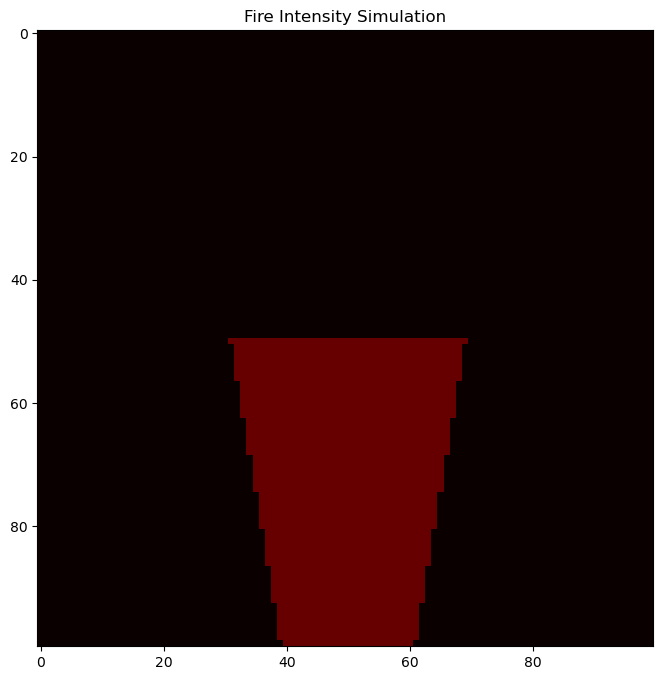

In [309]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

# Tamaño de la cuadrícula para la simulación
grid_size = 100

# Inicialización de la cuadrícula de intensidad del fuego
fire_grid = np.zeros((grid_size, grid_size))

# Punto de inicio del fuego, utilizando el centro de la cuadrícula
fire_start = (grid_size // 2, grid_size // 2)
fire_grid[fire_start] = 3455.373  # HFI

# Tasas de propagación [m/min] convertidas a índices de cuadrícula por paso de tiempo
# Suponiendo que cada unidad de cuadrícula representa 1 metro y cada paso de tiempo es 1 minuto
# Para simplificar, consideraremos la tasa de propagación como la cantidad de celdas afectadas por minuto
hros_steps = int(6.083)  # HROS convertido a pasos de cuadrícula
fros_steps = int(1.130)  # FROS convertido a pasos de cuadrícula
bros_steps = int(0.002)  # BROS convertido a pasos de cuadrícula, que es prácticamente 0 y puede ignorarse para la visualización

# Función para simular la propagación del fuego
def simulate_fire_propagation(step, fire_grid, hros_steps, fros_steps):
    new_fire_grid = np.copy(fire_grid)
    for i in range(grid_size):
        for j in range(grid_size):
            if fire_grid[i, j] > 0:
                # Propagar hacia adelante basado en HROS
                for h_step in range(1, hros_steps + 1):
                    if i + h_step < grid_size:
                        new_fire_grid[i + h_step, j] = 3455.373  # HFI
                # Propagar hacia los lados basado en FROS
                for f_step in range(1, fros_steps + 1):
                    if j + f_step < grid_size:
                        new_fire_grid[i, j + f_step] = 474.228  # FFI
                    if j - f_step >= 0:
                        new_fire_grid[i, j - f_step] = 474.228  # FFI
    return new_fire_grid

# Función para actualizar el gráfico
def update_plot(frame, fire_grid, hros_steps, fros_steps):
    global grid
    if frame > 0:  # Ignora el primer frame para mantener el punto de inicio visible
        grid = simulate_fire_propagation(frame, grid, hros_steps, fros_steps)
    plt.imshow(grid, cmap='hot', interpolation='nearest', vmin=0, vmax=3455.373)
    plt.title('Fire Intensity Simulation')

# Configuración de la animación
fig, ax = plt.subplots(figsize=(8, 8))
grid = np.copy(fire_grid)
ani = animation.FuncAnimation(fig, update_plot, fargs=(fire_grid, hros_steps, fros_steps),
                              frames=20, interval=200, repeat=False)

# Para visualizar en Jupyter Notebook
rc('animation', html='jshtml')
HTML(ani.to_jshtml())


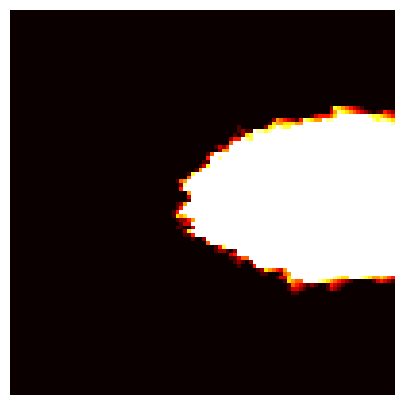

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

# Función para actualizar el fuego en la cuadrícula
def update_fire(grid, hros_t, hros_eq, hfi, cfb):
    """
    Función que actualiza la propagación del fuego en la cuadrícula.

    Parámetros:
        grid (numpy.ndarray): Cuadrícula que representa el estado actual del fuego.
        hros_t (float): Velocidad de propagación del fuego (m/min).
        hros_eq (float): Velocidad de propagación del fuego equivalente (m/min).
        hfi (float): Intensidad de la propagación del fuego (kW/m).
        cfb (float): Porcentaje de velocidad de propagación del fuego.

    Retorna:
        numpy.ndarray: Nueva cuadrícula con el estado actualizado del fuego.
    """
    new_grid = np.copy(grid)
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if grid[i, j] > 0:  # Si hay fuego en esta celda
                # Ajustar los parámetros de propagación según las funciones dadas
                hros_prob = hros_eq / 10  # Normalizamos HROS_eq para que esté en el rango de 0 a 1
                hfi_factor = hfi / 1000  # Normalizamos HFI para que esté en el rango de 0 a 1
                # Modificamos la probabilidad de propagación en la cabeza del fuego
                hros_prob *= (cfb / 100)  # Ajustamos la probabilidad en función de cfb
                # Modificamos la probabilidad de propagación en función de hfi
                hros_prob *= (1 + hfi_factor)  # Incrementa la probabilidad en función de HFI Factor
                for di in [-1, 0, 1]:
                    for dj in [-1, 0, 1]:
                        if 0 <= i + di < grid.shape[0] and 0 <= j + dj < grid.shape[1]:
                            if di == 0 and dj == 1:  # Hacia la derecha (cabeza del fuego)
                                prob = hros_prob
                            elif di in [-1, 1] or dj in [-1, 1]:  # Diagonal y flancos
                                prob = fros_prob
                            else:  # Hacia atrás y la propia celda
                                prob = bros_prob
                            if np.random.rand() < prob:
                                new_grid[i + di, j + dj] = min(10, grid[i + di, j + dj] + 1)  # Incrementa la intensidad del fuego
    return new_grid


# Configuración inicial
grid_size = 100
fire_grid = np.zeros((grid_size, grid_size))
start_point = grid_size // 2
fire_grid[start_point, start_point] = 1  # Inicia el fuego en el centro

# Parámetros de propagación (simplificados)
fros_prob = 0.02  # Probabilidad de propagación en los flancos
bros_prob = 0.05  # Probabilidad de propagación en el retroceso

# Parámetros secundarios
hros_t = 6.083  # [m/min]
hros_eq = 6.089  # [m/min]
hfi = 3455.373  # [kW/m]
cfb = 65.702  # [Percentage]

# Configuración de la animación
fig, ax = plt.subplots(figsize=(5, 5))

# Función de inicialización para la animación
def init():
    """
    Función de inicialización para la animación.
    Limpia el eje y muestra la cuadrícula inicial del fuego.
    """
    ax.clear()
    ax.imshow(fire_grid, cmap='hot', interpolation='nearest', vmin=0, vmax=10)  # Asigna la intensidad del fuego de 0 a 10
    plt.axis('off')

# Función de actualización para la animación
def update(frame):
    """
    Función de actualización para la animación.
    Actualiza el estado del fuego en cada frame de la animación.
    """
    global fire_grid
    ax.clear()
    fire_grid = update_fire(fire_grid, hros_t, hros_eq, hfi, cfb)
    ax.imshow(fire_grid, cmap='hot', interpolation='nearest', vmin=0, vmax=10)
    plt.axis('off')

# Crear animación
ani = animation.FuncAnimation(fig, update, frames=100, init_func=init, blit=False, interval=100, repeat=False)

# Mostrar la animación
HTML(ani.to_jshtml())


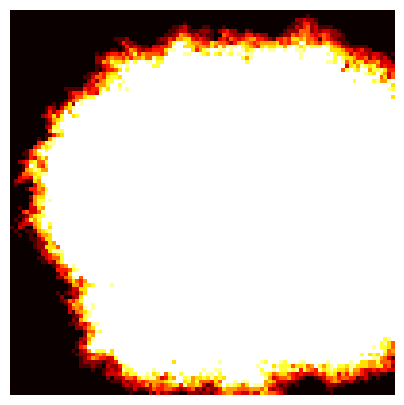

In [310]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

# Función para actualizar el fuego en la cuadrícula
def update_fire(grid, hros_t, hros_eq, hfi, cfb):
    """
    Función que actualiza la propagación del fuego en la cuadrícula.

    Parámetros:
        grid (numpy.ndarray): Cuadrícula que representa el estado actual del fuego.
        hros_t (float): Velocidad de propagación del fuego (m/min).
        hros_eq (float): Velocidad de propagación del fuego equivalente (m/min).
        hfi (float): Intensidad de la propagación del fuego (kW/m).
        cfb (float): Porcentaje de velocidad de propagación del fuego.

    Retorna:
        numpy.ndarray: Nueva cuadrícula con el estado actualizado del fuego.
    """
    new_grid = np.copy(grid)
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if grid[i, j] > 0:  # Si hay fuego en esta celda
                # Ajustar los parámetros de propagación según las funciones dadas
                # Por ejemplo, podemos utilizar HROS_eq para influir en la probabilidad de propagación en la cabeza del fuego
                hros_prob = hros_eq / 10  # Normalizamos HROS_eq para que esté en el rango de 0 a 1
                # Continuar con la lógica de propagación del fuego como antes
                for di in [-1, 0, 1]:
                    for dj in [-1, 0, 1]:
                        if 0 <= i + di < grid.shape[0] and 0 <= j + dj < grid.shape[1]:
                            if di == 0 and dj == 1:  # Hacia la derecha (cabeza del fuego)
                                prob = hros_prob
                            elif di in [-1, 1] or dj in [-1, 1]:  # Diagonal y flancos
                                prob = fros_prob
                            else:  # Hacia atrás y la propia celda
                                prob = bros_prob
                            if np.random.rand() < prob:
                                new_grid[i + di, j + dj] = min(10, grid[i + di, j + dj] + 1)  # Incrementa la intensidad del fuego
    return new_grid

# Configuración inicial
grid_size = 100
fire_grid = np.zeros((grid_size, grid_size))
start_point = grid_size // 2
fire_grid[start_point, start_point] = 1  # Inicia el fuego en el centro

# Parámetros de propagación (simplificados)
fros_prob = 0.1  # Probabilidad de propagación en los flancos
bros_prob = 0.05  # Probabilidad de propagación en el retroceso

# Parámetros secundarios
hros_t = 6.083  # [m/min]
hros_eq = 6.089  # [m/min]
hfi = 3455.373  # [kW/m]
cfb = 65.702  # [Percentage]

# Configuración de la animación
fig, ax = plt.subplots(figsize=(5, 5))

# Función de inicialización para la animación
def init():
    """
    Función de inicialización para la animación.
    Limpia el eje y muestra la cuadrícula inicial del fuego.
    """
    ax.clear()
    ax.imshow(fire_grid, cmap='hot', interpolation='nearest', vmin=0, vmax=10)  # Asigna la intensidad del fuego de 0 a 10
    plt.axis('off')

# Función de actualización para la animación
def update(frame):
    """
    Función de actualización para la animación.
    Actualiza el estado del fuego en cada frame de la animación.
    """
    global fire_grid
    ax.clear()
    fire_grid = update_fire(fire_grid, hros_t, hros_eq, hfi, cfb)
    ax.imshow(fire_grid, cmap='hot', interpolation='nearest', vmin=0, vmax=10)
    plt.axis('off')

# Crear animación
ani = animation.FuncAnimation(fig, update, frames=100, init_func=init, blit=False, interval=100, repeat=False)

# Mostrar la animación
HTML(ani.to_jshtml())


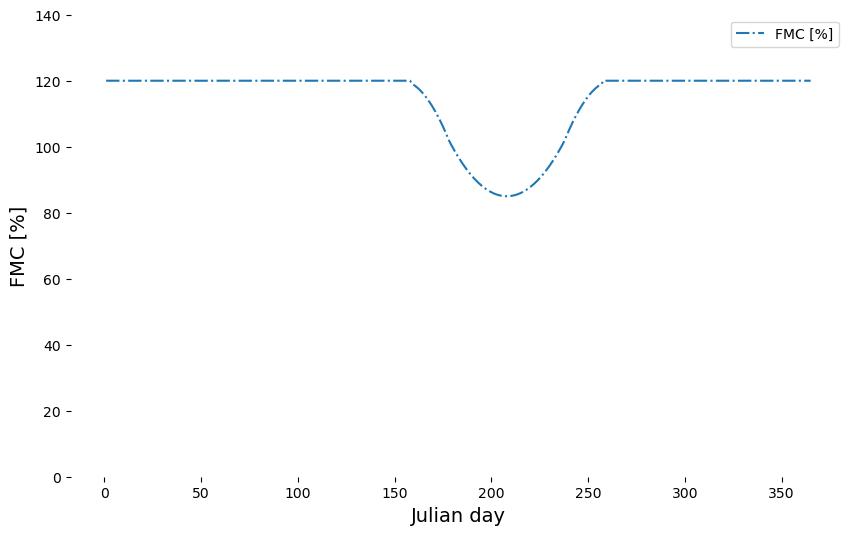

In [311]:
import matplotlib.pyplot as plt
import numpy as np



# Crear el rango de días julianos
x = np.arange(1, 366)  # 365 días
y = np.zeros_like(x, dtype=float)

# Calcular FMC para cada día juliano
for i in x:
    y[i-1] = foliar_moisture(lat, long, elev, i)

# Crear la figura y el gráfico
plt.figure(figsize=(10, 6))  # Tamaño opcional
plt.plot(x, y, '-.', label='FMC [%]')  # Etiqueta opcional para leyenda
plt.xlabel('Julian day', fontsize=14)
plt.ylabel('FMC [%]', fontsize=14)
plt.box(False)  # Deshabilitar el borde del gráfico
plt.ylim([0, 140])
plt.legend()  # Muestra la leyenda si es que se añadió una etiqueta en plt.plot
plt.show()


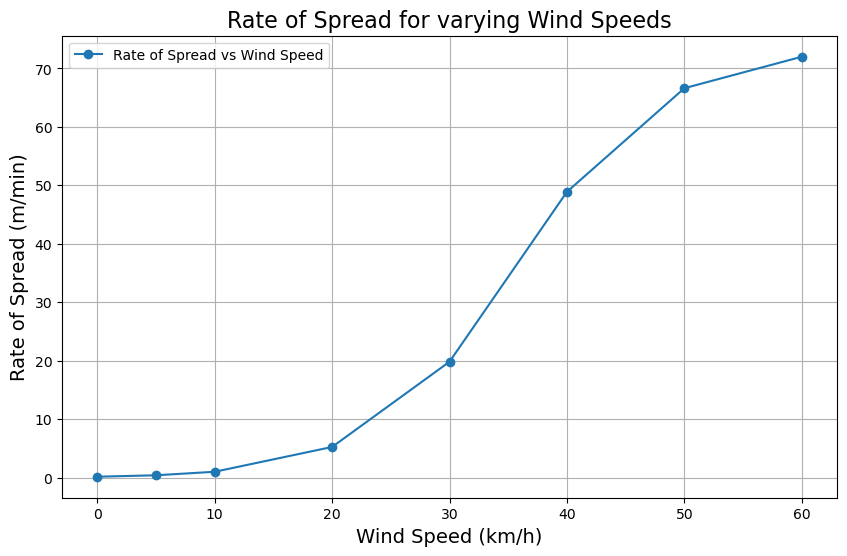

In [312]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Carga el DataFrame
ruta_archivo = '../test python preliminar/Weather.csv'
Weather = pd.read_csv(ruta_archivo)

# Seleccionar la primera fila del DataFrame para las simulaciones
wdfh = Weather.iloc[0].copy()

# Parámetros de entrada
ps = 0
saz = 0
x = np.array([0, 5, 10, 20, 30, 40, 50, 60])  # Velocidades del viento para la simulación
y = np.zeros(len(x))  # Para almacenar los resultados de ROS

# Asegúrate de que las constantes como ftype, a, b, c, FuelConst2, bui0, q están definidas

for i, ws in enumerate(x):
    # Actualizar la velocidad del viento en la fila seleccionada
    wdfh['WS'] = ws
    
    # Calcular la tasa de propagación del fuego para esta velocidad del viento
    # Como 'rate_of_spread' devuelve varios valores, y solo nos interesa el primero (ROS), usamos [0]
    # Asumiendo que 'rate_of_spread' puede trabajar directamente con una Serie de pandas como 'wdfh'
    ros, _, _, _ = rate_of_spread(ftype, wdfh, a, b, c, ps, saz, FuelConst2, bui0, q)
    y[i] = ros

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'o-', label='Rate of Spread vs Wind Speed')
plt.xlabel('Wind Speed (km/h)', fontsize=14)
plt.ylabel('Rate of Spread (m/min)', fontsize=14)
plt.legend()
plt.grid(True)  # Añade una cuadrícula al gráfico para mejor visualización
plt.title('Rate of Spread for varying Wind Speeds', fontsize=16)
plt.show()


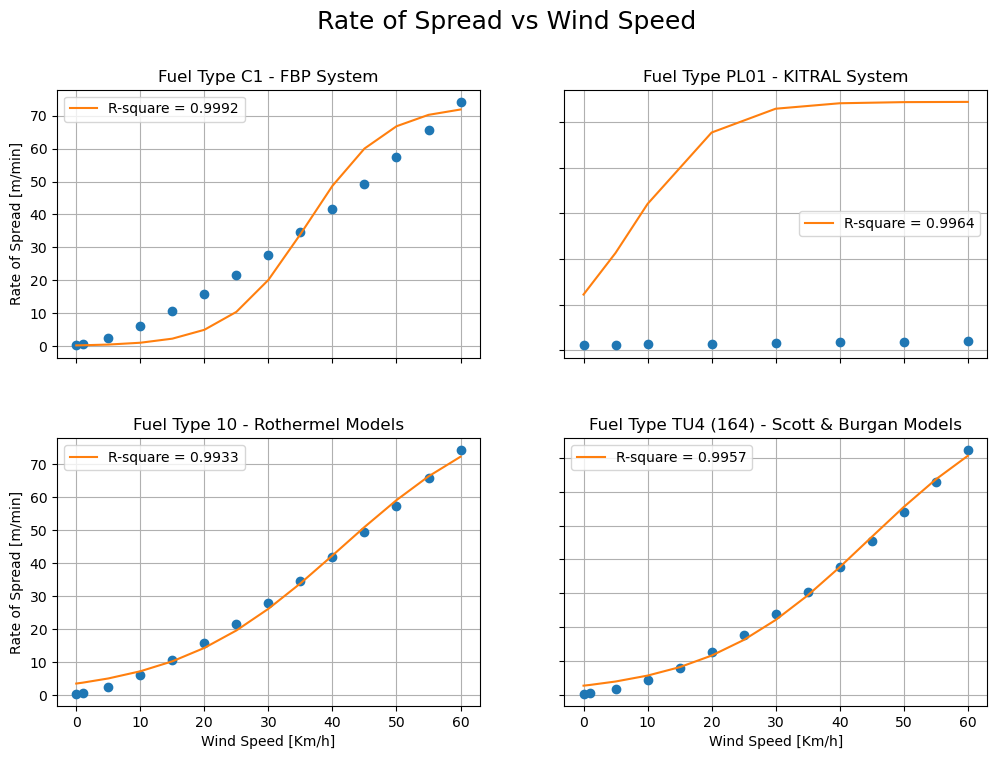

: 

In [313]:
import matplotlib.pyplot as plt
import numpy as np

# Función para la tasa de propagación del fuego
def fHROS(x, p1, p2, p3):
    return 1 / (p1 * np.exp(-p2 * x) + p3)

# Datos iniciales
x = np.array([0, 5, 10, 20, 30, 40, 50, 60])
x1 = np.array([0, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60])

# Configuración del layout de los subgráficos
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.subplots_adjust(hspace=0.3, wspace=0.2)
fig.suptitle('Rate of Spread vs Wind Speed', fontsize=18)

# Subgráfico 1: Fuel Type C1 - FBP System
y = np.array([0.4, 0.6, 2.5, 6.1, 10.6, 15.8, 21.5, 27.8, 34.6, 41.7, 49.3, 57.3, 65.6, 74.2])
axs[0, 0].plot(x1, y, 'o')  # Usar x1 en lugar de x
axs[0, 0].plot(x1, fHROS(x1, 5.223, 0.1658, 0.01366), label='R-square = 0.9992')  # Usar x1 aquí también
axs[0, 0].set_title('Fuel Type C1 - FBP System')
axs[0, 0].grid(True)
axs[0, 0].legend()

# Subgráfico 2: Fuel Type PL01 - KITRAL System
ws = np.array([0, 5, 10, 20, 30, 40, 50, 60])  # Velocidades del viento hipotéticas
# Suponiendo factores hipotéticos para el ejemplo
Fmc = 1.0  # Factor de combustible hipotético
Fch = 1.0  # Factor de carga hipotético
Fv = np.linspace(0.1, 1.0, len(ws))  # Factor de viento hipotético
HROSdataPL01 = Fmc * Fch * (1 + Fv)  # Cálculo simplificado de HROSdataPL01
axs[0, 1].plot(ws, HROSdataPL01, 'o')
axs[0, 1].plot(ws, fHROS(ws, 0.06332, 0.1599, 0.01836), label='R-square = 0.9964')
axs[0, 1].set_title('Fuel Type PL01 - KITRAL System')
axs[0, 1].grid(True)
axs[0, 1].legend()

# Subgráfico 3: Fuel Type 10 - Rothermel Models
y1 = np.array([0.4, 0.6, 2.5, 6.1, 10.6, 15.8, 21.5, 27.8, 34.6, 41.7, 49.3, 57.3, 65.6, 74.2])
axs[1, 0].plot(x1, y1, 'o')
axs[1, 0].plot(x1, fHROS(x1, 0.2802, 0.07786, 0.01123), label='R-square = 0.9933')
axs[1, 0].set_title('Fuel Type 10 - Rothermel Models')
axs[1, 0].grid(True)
axs[1, 0].legend()

# Subgráfico 4: Fuel Type TU4 (164) - Scott & Burgan Models
y1 = np.array([0.6, 0.8, 3.1, 8.5, 15.9, 24.9, 35.5, 47.5, 60.8, 75.3, 91.0, 107.9, 125.8, 144.7])
axs[1, 1].plot(x1, y1, 'o')
axs[1, 1].plot(x1, fHROS(x1, 0.1843, 0.07911, 0.005477), label='R-square = 0.9957')
axs[1, 1].set_title('Fuel Type TU4 (164) - Scott & Burgan Models')
axs[1, 1].grid(True)
axs[1, 1].legend()

# Ajuste de las etiquetas de los ejes para todos los subgráficos
for ax in axs.flat:
    ax.set(xlabel='Wind Speed [Km/h]', ylabel='Rate of Spread [m/min]')
    ax.label_outer()  # Oculta las etiquetas x y y para los subgráficos internos

plt.show()
